## Pre-requisite Libraries

In [ ]:
#%pip install wordcloud
#%pip install -U textblob

## Import necessary Libraries

In [1]:
import os
import json
import gzip
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from urllib.request import urlopen
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from sklearn.metrics import mean_absolute_error 
import random

In [2]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

In [3]:
import nltk
from wordcloud import WordCloud
from textblob import TextBlob
nltk.download('punkt')
nltk.download('stopwords')
import csv

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dkarthikeyanucsd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dkarthikeyanucsd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load dataset

In [ ]:
data = []
with open("reviews_Movies_and_TV.json", 'r') as f:
    for line in f:
        data.append(json.loads(line))

In [ ]:
len(data)

In [ ]:
data[:1]

In [ ]:
random.shuffle(data)
#movies_df = pd.DataFrame(data[:500000])

In [ ]:
with open('reviews_movies_50k.json', 'w') as output_file:
    json.dump(data[:500000], output_file)

## Load truncated data

In [4]:
movies_df = pd.read_json("reviews_movies_50k.json")
len(movies_df)

500000

In [5]:
#Display loaded dataset
movies_df[:5]

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2D3YJ1U6Z12HC,B0002MJT0I,Horror Metal Girl 6,"[0, 0]",Where do I begin? This movie has it all! Cle...,5,Quite possibly the most perfect movie ever made.,1209600000,"05 1, 2008"
1,A1FZ4AHRIDC94R,B00CJLCON4,Ladybug,"[1, 1]",My girls watch this video at least twice a wee...,5,Awesome gift,1399420800,"05 7, 2014"
2,A2DSLFC0AHDBJB,B002JVWRD6,Koko,"[0, 0]",This is a great series. The only problem I ha...,5,Excellent,1360454400,"02 10, 2013"
3,A1426KH3FP7F1R,B0010DR4BO,"T. Suzanne Eller ""(Suzie)""","[2, 3]",Beautiful film that is almost like art to watc...,5,Beautiful film w/powerful story,1227484800,"11 24, 2008"
4,AZS3LXP5HOV0L,B0053O89WY,Aubrei,"[3, 4]","This series was hilariously funny at first, bu...",2,"Less Nerdy, More Soap Opera",1386374400,"12 7, 2013"


## Helpfulness Index Estimation

In [6]:
# Calculate the helpfulnessIndex and add a new column
movies_df['helpfulnessIndex'] = movies_df['helpful'].apply(lambda x: x[0] / x[1] if x[1] != 0 else 0)

In [7]:
movies_df = movies_df[movies_df['helpfulnessIndex'] != 0]

In [8]:
movies_df = movies_df[movies_df['helpfulnessIndex'] <= 1.0]

In [9]:
#Find movies whose review count is GT 10
movies_df = movies_df.groupby('asin').filter(lambda x: len(x) >= 10)
print(len(movies_df))

108571


## Exploratory Data Analysis

In [10]:
movies_df['reviewTextLength'] = movies_df['reviewText'].apply(len)

In [11]:
movies_df.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpfulnessIndex,reviewTextLength
3,A1426KH3FP7F1R,B0010DR4BO,"T. Suzanne Eller ""(Suzie)""","[2, 3]",Beautiful film that is almost like art to watc...,5,Beautiful film w/powerful story,1227484800,"11 24, 2008",0.666667,444
4,AZS3LXP5HOV0L,B0053O89WY,Aubrei,"[3, 4]","This series was hilariously funny at first, bu...",2,"Less Nerdy, More Soap Opera",1386374400,"12 7, 2013",0.750000,420
9,A11F6QQ2J1H6K9,B002RVZV9K,D. de Gruchy,"[1, 1]",It Might Get Loud is one of those rare movies ...,5,Just phenominal,1268438400,"03 13, 2010",1.000000,397
15,AJA89FNC1J1FT,6304983794,J. Nelson,"[3, 4]","This is my favorite Zombie film, and Horror fi...",5,VIVA TOM SAVINI!!,1159142400,"09 25, 2006",0.750000,589
20,A2SXHP3384ER6W,6302642493,SailorJoe,"[1, 1]",This classic muppet movie will evoke memories ...,5,The first and the best,1347321600,"09 11, 2012",1.000000,328


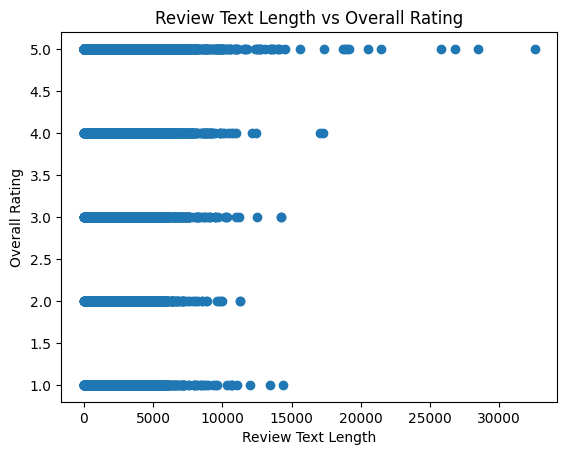

In [12]:
# Plotting
plt.scatter(movies_df['reviewTextLength'], movies_df['overall'])
plt.title('Review Text Length vs Overall Rating')
plt.xlabel('Review Text Length')
plt.ylabel('Overall Rating')
plt.show()

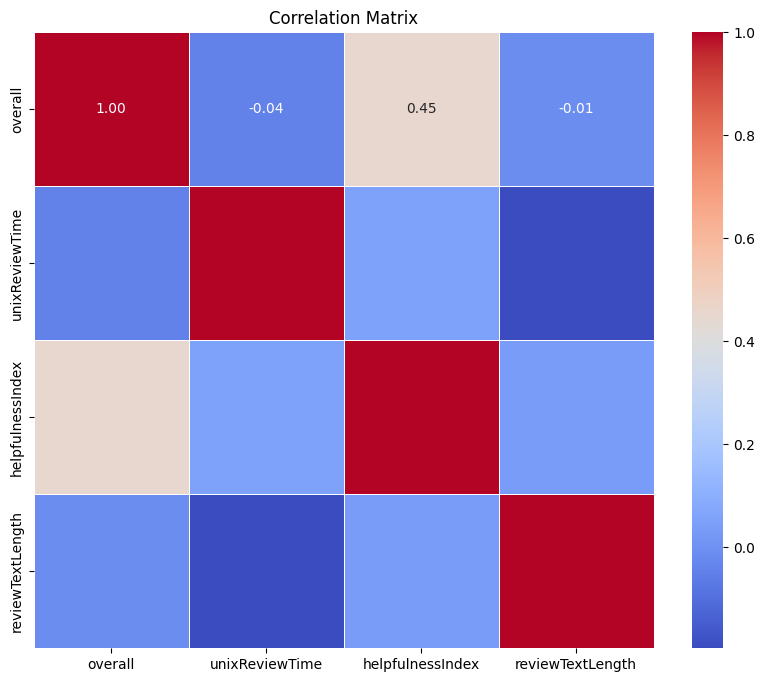

In [13]:
# Drop non-numeric columns
numeric_df = movies_df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plotting a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()
#print(len(movies_df), movies_df[:1])

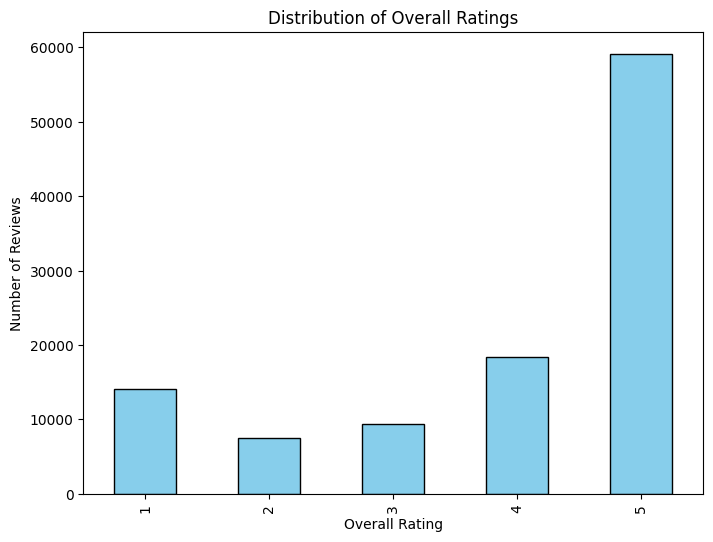

In [14]:
# Plotting a bar chart
plt.figure(figsize=(8, 6))
movies_df['overall'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Overall Ratings')
plt.xlabel('Overall Rating')
plt.ylabel('Number of Reviews')
plt.show()

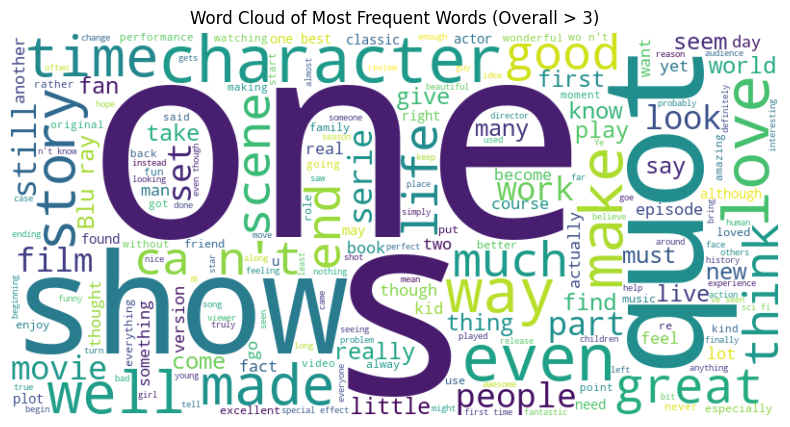

In [15]:
# Filter rows where 'overall' is greater than equal to 4.
filtered_df = movies_df[movies_df['overall'] >= 4]

# Combine 'reviewText' for all rows
text = ' '.join(filtered_df['reviewText'].astype(str).tolist())

# Tokenize the text
tokens = word_tokenize(text)

# Remove stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(("movie", "film", "see", "watch", "dvd"))
filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

# Join the filtered tokens into a single string
filtered_text = ' '.join(filtered_tokens)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words (Overall > 3)')
plt.show()

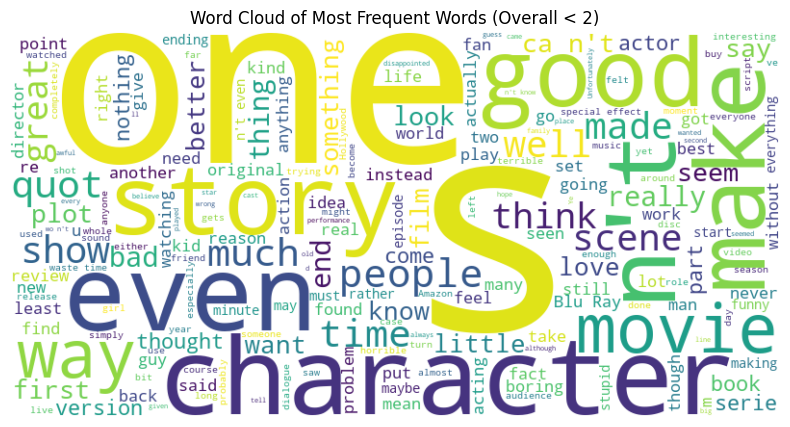

In [16]:
# Filter rows where 'overall' is less than 2
filtered_df = movies_df[movies_df['overall'] <= 2]

# Combine 'reviewText' for all rows
text = ' '.join(filtered_df['reviewText'].astype(str).tolist())

# Tokenize the text
tokens = word_tokenize(text)

# Remove stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(("movie", "film", "see", "watch", "dvd"))
filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

# Join the filtered tokens into a single string
filtered_text = ' '.join(filtered_tokens)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words (Overall < 2)')
plt.show()

{'one': 76074, 'like': 56345, 'great': 43934, 'good': 43278, 'would': 41304, 'time': 37888, 'story': 36386, 'really': 34551, 'even': 31798, 'first': 31765, 'much': 31143, 'get': 30652, 'well': 30328, 'love': 28403, 'quot': 25967, 'people': 25562, 'best': 24278, 'many': 22964, 'way': 22839, 'think': 21779}


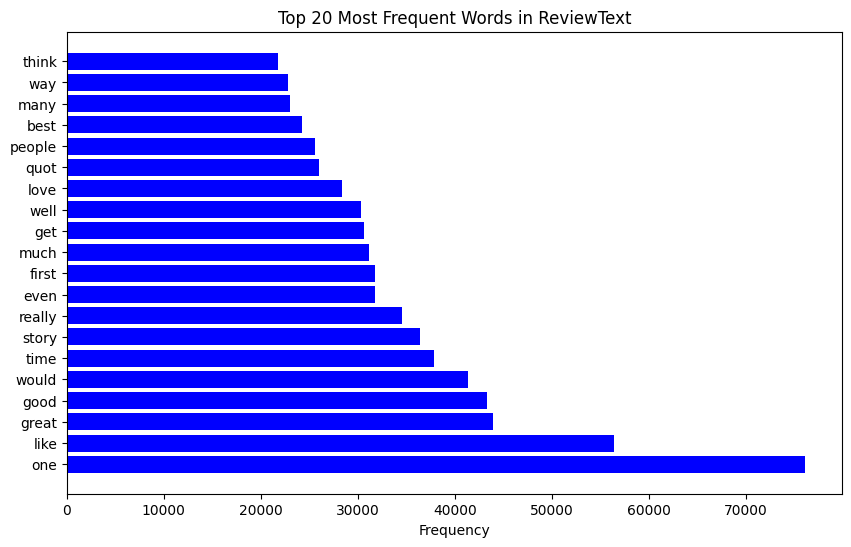

In [17]:
# Combine 'reviewText' for all rows
text = ' '.join(movies_df['reviewText'].astype(str).tolist())

# Tokenize the text
tokens = word_tokenize(text)

# Remove stopwords and non-alphanumeric words
stop_words = set(stopwords.words('english'))
stop_words.update(("movie", "film", "see", "watch", "dvd", "could", "also", "movies"))
filtered_tokens = [word.lower() for word in tokens if word.isalnum() and word.lower() not in stop_words]

# Get the 20 most frequent words
word_counts = Counter(filtered_tokens)
top_20_words = dict(word_counts.most_common(20))

# Display the 20 most frequent words
print(top_20_words)

# Plotting the horizontal bar graph
plt.figure(figsize=(10, 6))
plt.barh(list(top_20_words.keys()), list(top_20_words.values()), color='blue')
plt.xlabel('Frequency')
plt.title('Top 20 Most Frequent Words in ReviewText')
plt.show()

/Users/dinesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dinesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dinesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Users/dinesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) in

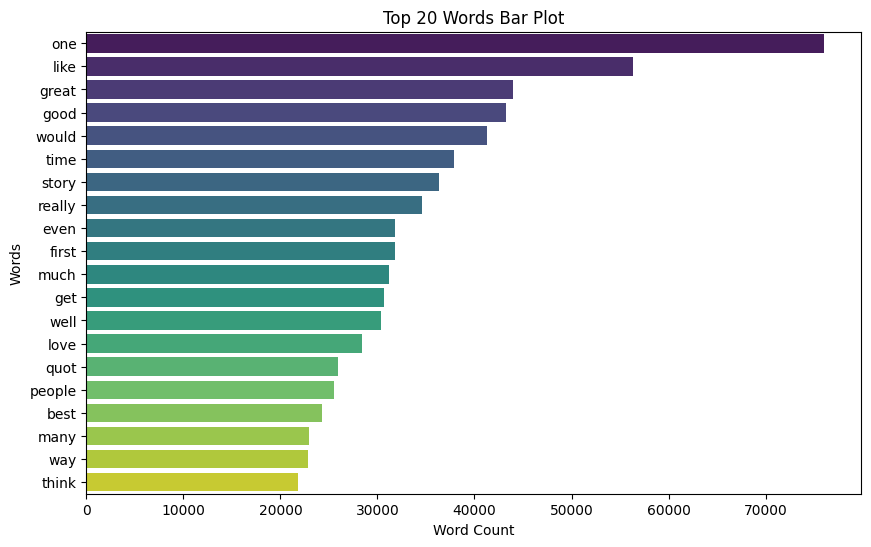

In [18]:
# Plotting the horizontal bar graph
plt.figure(figsize=(10, 6))
custom_palette = sns.color_palette("viridis", n_colors=len(top_20_words))
sns.barplot(x=list(top_20_words.values()), y=list(top_20_words.keys()), palette=custom_palette)
plt.title('Top 20 Words Bar Plot')
plt.xlabel('Word Count')
plt.ylabel('Words')
plt.show()

In [19]:
# Get bigrams and trigrams
bigrams = list(ngrams(filtered_tokens, 2))
trigrams = list(ngrams(filtered_tokens, 3))

# Get the 20 most frequent bigrams and trigrams
top_20_bigrams = dict(Counter(bigrams).most_common(20))
top_20_trigrams = dict(Counter(trigrams).most_common(20))

/Users/dinesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dinesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dinesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Users/dinesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) in

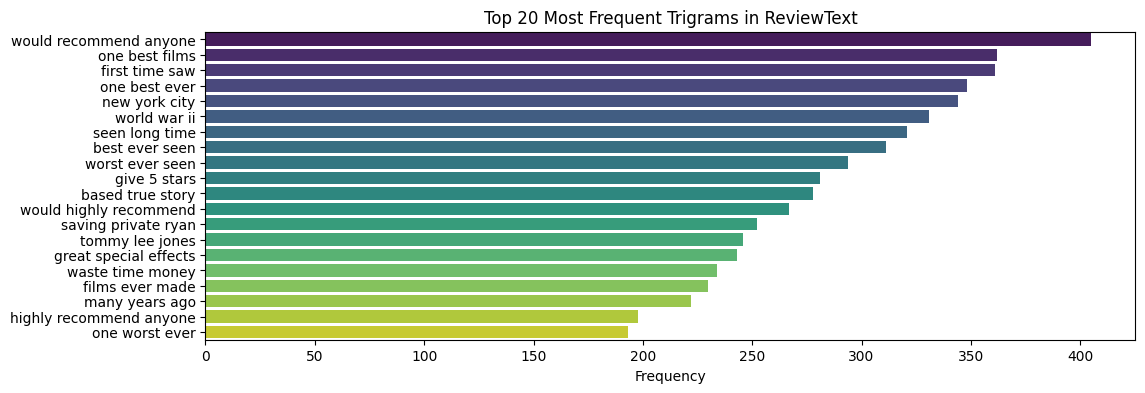

In [20]:
# Plot Top 20 Freuently Used Trigrams 
plt.figure(figsize=(12, 4))
custom_palette = sns.color_palette("viridis", n_colors=len(top_20_trigrams))
sns.barplot(x=list(top_20_trigrams.values()), y=[' '.join(trigram) for trigram in top_20_trigrams.keys()], palette=custom_palette)
plt.xlabel('Frequency')
plt.title('Top 20 Most Frequent Trigrams in ReviewText')
plt.show()

/Users/dinesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dinesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dinesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Users/dinesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) in

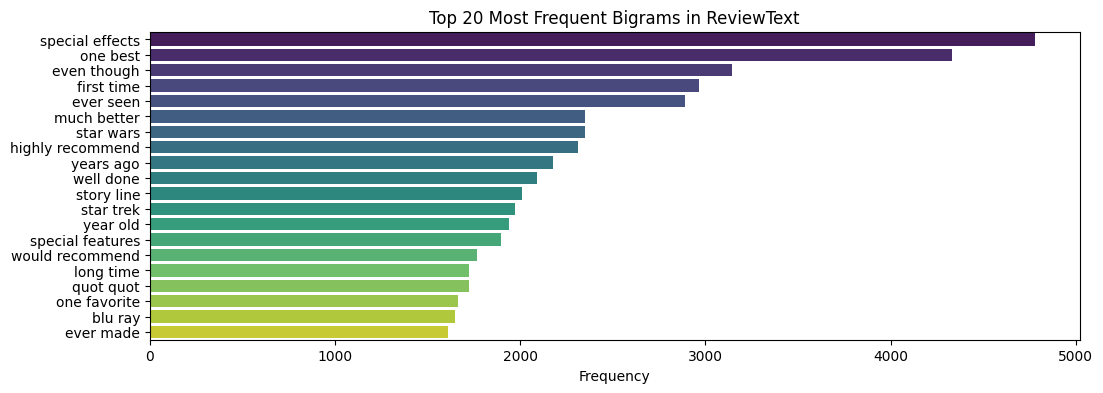

In [21]:
# Plot Top 20 Freuently Used Bigrams 
plt.figure(figsize=(12, 4))
custom_palette = sns.color_palette("viridis", n_colors=len(top_20_bigrams))
sns.barplot(x=list(top_20_bigrams.values()), y=[' '.join(bigram) for bigram in top_20_bigrams.keys()], palette=custom_palette)
plt.xlabel('Frequency')
plt.title('Top 20 Most Frequent Bigrams in ReviewText')
plt.show()

### Polarity of a Review

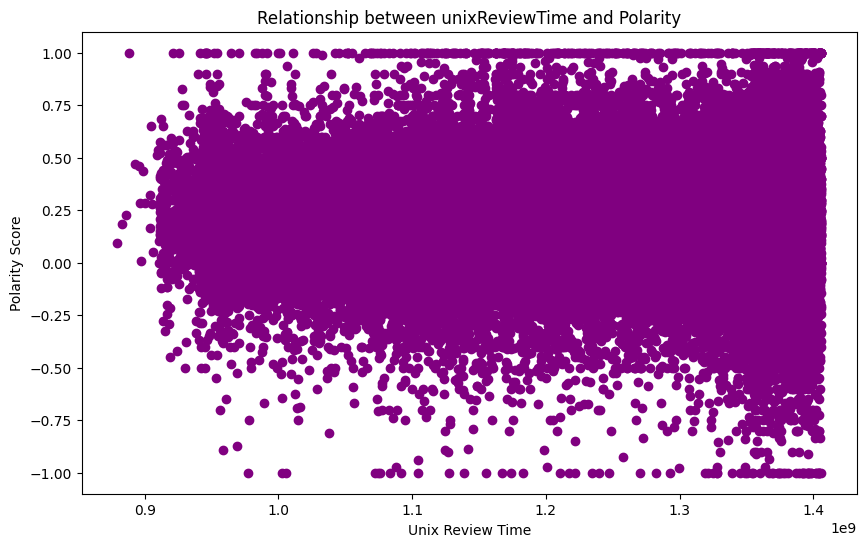

In [22]:
# Calculate polarity for each review
movies_df['polarity'] = movies_df['reviewText'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Scatter plot of unixReviewTime against polarity
plt.figure(figsize=(10, 6))
plt.scatter(movies_df['unixReviewTime'], movies_df['polarity'], color='purple')
plt.title('Relationship between unixReviewTime and Polarity')
plt.xlabel('Unix Review Time')
plt.ylabel('Polarity Score')
plt.show()

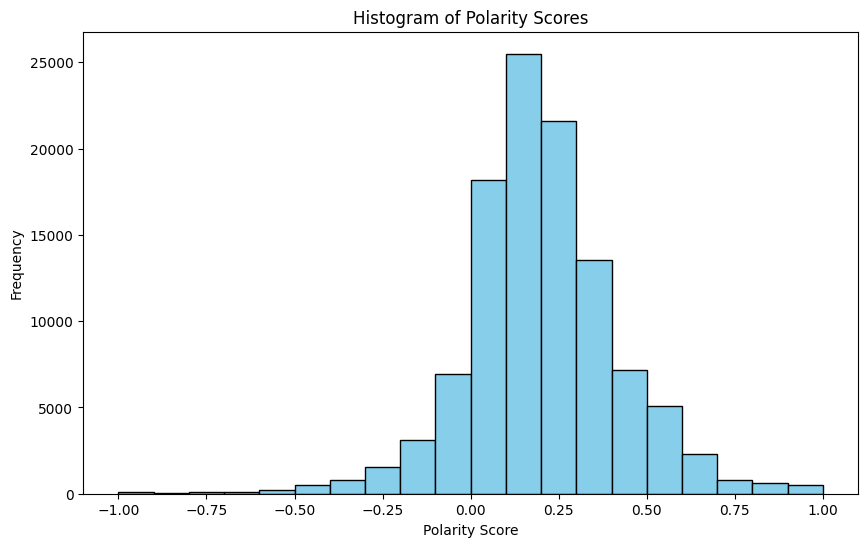

In [23]:
# Plotting a histogram of polarity scores
plt.figure(figsize=(10, 6))
plt.hist(movies_df['polarity'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Polarity Scores')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.show()

/Users/dinesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dinesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


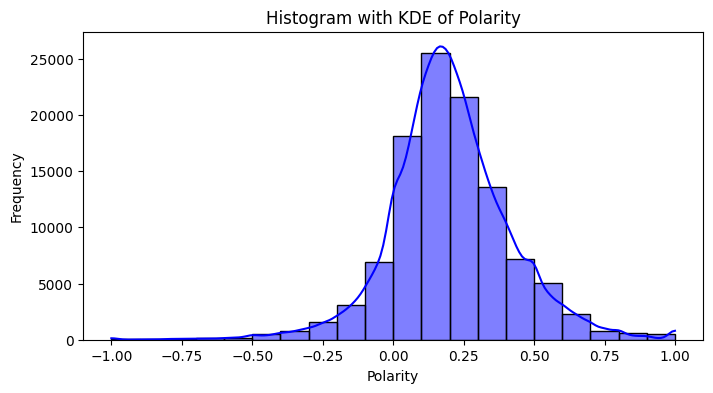

In [24]:
plt.figure(figsize=(8, 4))
sns.histplot(movies_df['polarity'], bins=20, color='blue', kde=True, edgecolor='black')

# Set labels and title
plt.title('Histogram with KDE of Polarity')
plt.xlabel('Polarity')
plt.ylabel('Frequency')

# Show the plot
plt.show()

/Users/dinesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dinesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dinesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


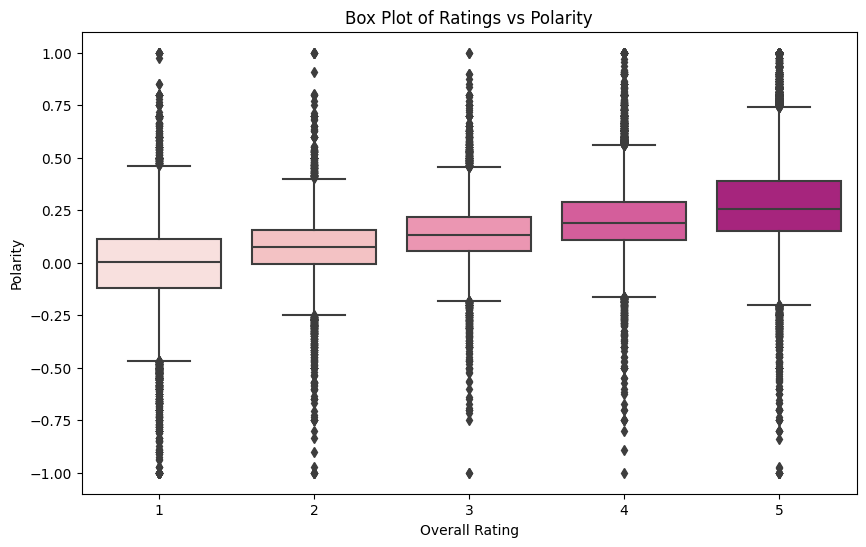

In [25]:
# Plot Rating Vs Polarity
plt.figure(figsize=(10, 6))
custom_palette = sns.color_palette('RdPu')
sns.boxplot(x='overall', y='polarity', data=movies_df[:], palette=custom_palette)
plt.title('Box Plot of Ratings vs Polarity')
plt.xlabel('Overall Rating')
plt.ylabel('Polarity')
plt.show()

/Users/dinesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dinesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dinesh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


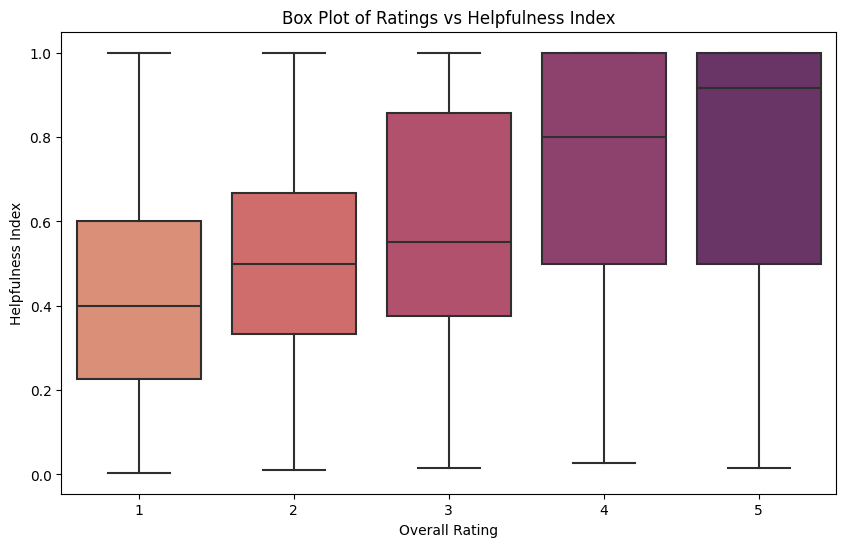

In [26]:
# Create a box plot of ratings vs helpfulnessIndex using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='overall', y='helpfulnessIndex', data=movies_df[:], palette='flare')
plt.title('Box Plot of Ratings vs Helpfulness Index')
plt.xlabel('Overall Rating')
plt.ylabel('Helpfulness Index')
plt.show()

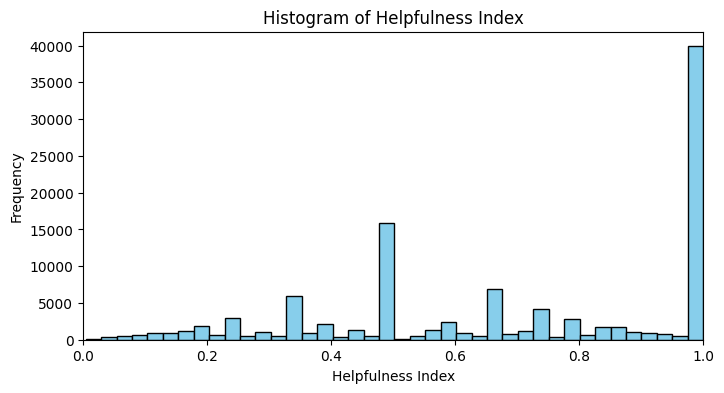

In [27]:
#Plotting Histograms for Helpfulness index
plt.figure(figsize=(8, 4))
plt.hist(movies_df['helpfulnessIndex'], bins=40, color='skyblue', edgecolor='black')
#sns.histplot(helpfulness_index, kde=True, color='skyblue', edgecolor='black')
plt.title('Histogram of Helpfulness Index')
plt.xlabel('Helpfulness Index')
plt.ylabel('Frequency')
plt.xlim(0, 1)
plt.show()

## Feature Engineering 

In [28]:
#Creating average rating of a movie
average_ratings_by_movie = movies_df.groupby('asin')['overall'].mean().reset_index()

# Create a new DataFrame to store the results
average_ratings_df = pd.DataFrame({
    'asin': average_ratings_by_movie['asin'],
    'average_rating': average_ratings_by_movie['overall']
})

### Confirmity Hypothesis

In [29]:
merged_df = pd.merge(movies_df, average_ratings_df, on='asin', how='left')
merged_df['Confirmity_Val'] = merged_df['overall'] - merged_df['average_rating']
merged_df['Confirmity_Val'].fillna(0, inplace=True)

In [30]:
# Assigning Confirmity Value
movies_df['Confirmity_Val'] = merged_df['Confirmity_Val']
movies_df['Confirmity_Val'].fillna(0, inplace=True)

In [31]:
# Number of reviews for a movie
movies_df['Num_Reviews'] = movies_df['asin'].map(movies_df.groupby('asin')['reviewerID'].count())

In [32]:
# Number of reviews given by user
movies_df['Review_By_User'] = movies_df['reviewerID'].map(movies_df.groupby('reviewerID')['asin'].count())

In [33]:
#Age of a review calculation
from dateutil import parser

movies_df['Review_Date'] = movies_df['reviewTime'].apply(lambda x: parser.parse(x))
# Set the reference date
reference_date = pd.to_datetime('2015-01-01')
# Calculate the days difference
movies_df['Days_Difference'] = (reference_date - movies_df['Review_Date']).dt.days
print(movies_df[['reviewTime', 'Review_Date', 'Days_Difference']])

         reviewTime Review_Date  Days_Difference
3       11 24, 2008  2008-11-24             2229
4        12 7, 2013  2013-12-07              390
9       03 13, 2010  2010-03-13             1755
15      09 25, 2006  2006-09-25             3020
20      09 11, 2012  2012-09-11              842
...             ...         ...              ...
499970  01 12, 2006  2006-01-12             3276
499982  08 13, 2011  2011-08-13             1237
499989   08 4, 2005  2005-08-04             3437
499992  02 11, 2012  2012-02-11             1055
499997   12 6, 2010  2010-12-06             1487

[108571 rows x 3 columns]


In [34]:
# Assuming 'Days_Difference' is the column you want to scale
min_days = movies_df['Days_Difference'].min()
max_days = movies_df['Days_Difference'].max()

# Apply Min-Max Scaling
movies_df['Scaled_Days_Difference'] = (movies_df['Days_Difference'] - min_days) / (max_days - min_days)

In [35]:
#Calculating # of people voted for a review
movies_df['Second_Number'] = movies_df['helpful'].apply(lambda x: x[1])

# Add a new column Higher_HR
movies_df['Higher_HR'] = 0  # Initialize with 0
condition = (movies_df['Second_Number'] > 20) & (movies_df['helpfulnessIndex'] >= 0.75)
movies_df.loc[condition, 'Higher_HR'] = 1

# Display the updated DataFrame
print(movies_df[['Second_Number', 'helpfulnessIndex', 'Higher_HR']])

        Second_Number  helpfulnessIndex  Higher_HR
3                   3          0.666667          0
4                   4          0.750000          0
9                   1          1.000000          0
15                  4          0.750000          0
20                  1          1.000000          0
...               ...               ...        ...
499970              8          0.875000          0
499982              8          0.625000          0
499989             18          0.277778          0
499992              1          1.000000          0
499997              1          1.000000          0

[108571 rows x 3 columns]


In [36]:
#Number of reviewers & movies
distinct_reviewers_count = movies_df['reviewerID'].nunique()
distinct_movies_count = movies_df['asin'].nunique()

print("Number of distinct reviewers:", distinct_reviewers_count)
print("Number of distinct movies:", distinct_movies_count)

Number of distinct reviewers: 83811
Number of distinct movies: 4706


In [37]:
features = movies_df[['unixReviewTime', 'reviewTextLength', 'polarity', 'overall', 'Confirmity_Val', 'Num_Reviews', 'Review_By_User', 'Scaled_Days_Difference', 'Higher_HR']]
labels = movies_df['helpfulnessIndex'].tolist()

In [38]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

### Data Partitioning

In [39]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

## Baseline

In [40]:
# Baseline
mean_helpfulness_index = movies_df['helpfulnessIndex'].mean()
med_helpfulness_index = movies_df['helpfulnessIndex'].median()
y_pred_1 = [med_helpfulness_index for a in range(0,len(X_test))]
mse = mean_squared_error(y_test, y_pred_1)
mae = mean_absolute_error(y_test, y_pred_1)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 0.08414469969763146
Mean Absolute Error: 0.25555382381446407


## Linear Regression

In [41]:
# Model Training
model = LinearRegression()
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Mean Absolute Error: 0.21906037341049558
Mean Squared Error: 0.06450890570611553


## Gradient Boosting

In [42]:
# Model Training - XGBoost for Regression
model = XGBRegressor()
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Mean Absolute Error: 0.19921784252000294
Mean Squared Error: 0.057099676688402747


## Random Forest Regressor

In [43]:
# Model Training - Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, max_depth=None,  max_features='log2', bootstrap=True)
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Mean Absolute Error: 0.20317832587047685
Mean Squared Error: 0.0594155168467341


## Ridge Regression

In [44]:
# Model Training - Ridge Regression
alpha = 1.0  # Regularization strength (you can adjust this parameter)
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train, y_train)

# Model Evaluation
y_pred = ridge_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Mean Absolute Error: 0.21905995226560082
Mean Squared Error: 0.06450886304836788


/Users/dinesh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=6.68858e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


## Decision Tree Regressor

In [45]:
# Model Training - Decision Tree Regression
decision_tree_model = DecisionTreeRegressor()
decision_tree_model.fit(X_train, y_train)

# Model Evaluation
y_pred = decision_tree_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Mean Absolute Error: 0.24275900107687567
Mean Squared Error: 0.11027193347980434
